# Finding Probability of Default

<p>The purpose of this notebook is to predict a probability that, given my finances, I will default on a car loan. Hypothetically, I am aiming to take out a \\$10,000 car loan, I am a recent college grad and need a car to get to my new job. Should the bank approve, or decline, my request to take out a \\$10,000 car loan.</p><p> The data is Lending Club data from 2014, some data has been cleaned prior to being loaded into this notebook.</p>

In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('lendingclub_2014_ng.csv')

C:\Users\Thom\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (15,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,36805548,NaN,10400,10400,10400,36 months,321.08,Truck Driver Delivery Personel,8 years,MORTGAGE,58000.0,Not Verified,Dec-14,Charged Off,n,NaN,credit_card,Credit card refinancing,937xx,CA,14.92,0,Sep-89,710,714,2,42.0,NaN,17,0,6133,31.60%,36,w,0.0,0.0,6611.69000,6611.69,5217.75,872.67,0.0,521.27,93.8286,Aug-16,321.08,NaN,Feb-17,564,560,0,59.0,1,Individual,NaN,NaN,NaN,0,0,162110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19400,NaN,NaN,NaN,7,9536.0,7599.0,41.5,0,0,76.0,290,1,1,1,5.0,42.0,1.0,42.0,4,6,9,7,18,2,14,32,9,17,0.0,0,0,4,83.3,14.3,0,0,179407,15030,13000,11325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,38098114,NaN,15000,15000,15000,60 months,336.64,MANAGEMENT,10+ years,RENT,78000.0,Source Verified,Dec-14,Fully Paid,n,NaN,debt_consolidation,Debt consolidation,235xx,VA,12.03,0,Aug-94,750,754,0,NaN,NaN,6,0,138008,29%,17,w,0.0,0.0,17392.37000,17392.37,15000.00,2392.37,0.0,0.00,0.0000,Jun-16,12017.81,NaN,Nov-19,684,680,0,NaN,1,Individual,NaN,NaN,NaN,0,0,149140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184500,NaN,NaN,NaN,5,29828.0,9525.0,4.7,0,0,103.0,244,1,1,0,47.0,NaN,NaN,NaN,0,1,4,1,2,8,5,9,4,6,0.0,0,0,4,100.0,0.0,0,0,196500,149140,10000,12000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,37822187,NaN,9600,9600,9600,36 months,326.53,Admin Specialist,10+ years,RENT,69000.0,Source Verified,Dec-14,Fully Paid,n,NaN,debt_consolidation,Debt consolidation,077xx,NJ,25.81,0,Nov-92,680,684,0,NaN,NaN,12,0,16388,59.40%,

To get a better idea of what the ```loan_status``` feature looks like, I generate a bar chart of the counts for each value in ```loan_status```. This is done using ```.value_counts()``` and using the pandas series that is made with that function to then build the bar chart in ```matplotlib.pyplot```.

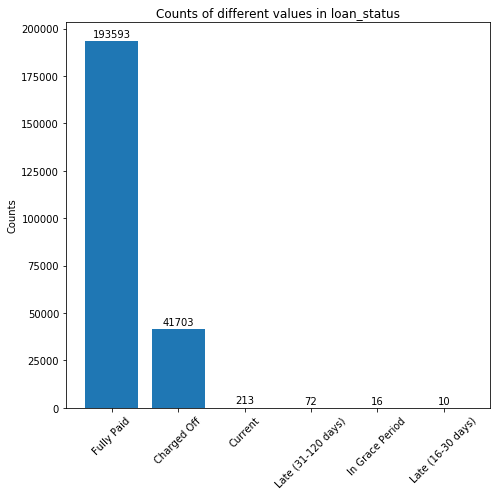

In [6]:
loan_counts = df['loan_status'].value_counts()

# x axis
x = np.arange(len(loan_counts))

# plotting counts
fig,ax = plt.subplots(figsize=(7,7))
rect = plt.bar(x,loan_counts)
plt.xticks(x,loan_counts.index,rotation=45)
plt.ylabel('Counts')
plt.title('Counts of different values in loan_status')

def autolabel(rects,formatting):
    '''Function to add labels to bars'''
    for rect in rects:
        height = rect.get_height()
        ax.annotate(formatting % (height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rect,'%i')
        
fig.tight_layout()
plt.show()

<p>The purpose of this notebook is to predict a probability I will default on a car loan. We use the loan status from loans on the LendingClub platform to build our classifier. Fully paid loans will be considered not defaulted, Charged Off loans will be considered defaulted. </p>
<p>About 20% of our data are Charged Off accounts. This number should be reflected in the final classifier to show 20% of predicted are Charged Off.</p>

In [7]:
# mask to slim dataset down to paid off and defaulted loans
mask = (df['loan_status']=='Fully Paid') | (df['loan_status']=='Charged Off')
df = df[mask]

In [8]:
# creating default feature to predict on
df['default'] = np.where(df['loan_status']=='Charged Off',1,0)

<p>Fields to use for our analysis:</p>

* loan_amnt
* term
* annual_inc
* purpose
* dti
* fico_range_high
* acc_open_past_24mths
* tot_cur_bal
* bc_util
* mort_acc 

<p> I've selected these features since they will be easy features to get from my own finances. </p>

In [9]:
# use these columns
usecols = ['loan_amnt','term','annual_inc','purpose','dti','fico_range_high',
           'acc_open_past_24mths','tot_cur_bal','bc_util','mort_acc','default']

In [10]:
# overwrite dataframe with dataframe of features we want
df = df[usecols]

A Pearson correlation coefficient matrix will give us a better idea of which features correlate best with default. I generate this with pandas function ```.corr()```. I then build out a bar chart in ```matplotlib.pyplot```. Labels are generated with the label function used earlier.

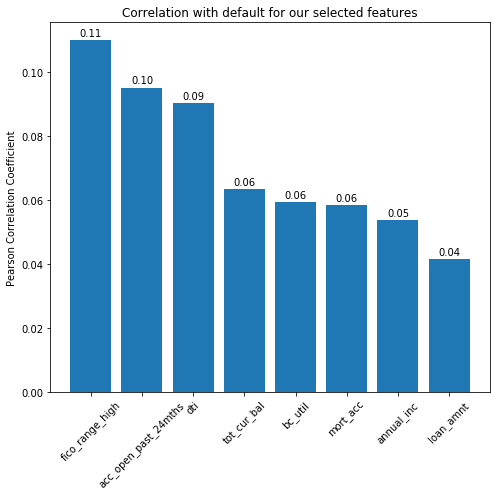

In [11]:
# absolute value of correlations with default
corr = np.abs(df.corr()['default']).sort_values(ascending=False)

# x axis
x = np.arange(len(corr))

# plotting correlations
fig,ax = plt.subplots(figsize=(7,7))
rect = plt.bar(x[1:],corr[1:])
plt.xticks(x[1:],corr.index[1:],rotation=45)
plt.ylabel('Pearson Correlation Coefficient')
plt.title('Correlation with default for our selected features')

autolabel(rect,'%.2f')
        
fig.tight_layout()
plt.show()

In [12]:
df.head()

,loan_amnt,term,annual_inc,purpose,dti,fico_range_high,acc_open_past_24mths,tot_cur_bal,bc_util,mort_acc,default
0,10400,36 months,58000.0,credit_card,14.92,714,7,162110,41.5,1,1
1,15000,60 months,78000.0,debt_consolidation,12.03,754,5,149140,4.7,0,0
2,9600,36 months,69000.0,debt_consolidation,25.81,684,8,38566,69.2,0,0
3,12800,60 months,125000.0,car,8.31,669,2,261815,103.2,5,0
4,21425,60 months,63800.0,credit_card,18.49,689,4,42315,97.8,0,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235296 entries, 0 to 235606
Data columns (total 11 columns):
loan_amnt               235296 non-null int64
term                    235296 non-null object
annual_inc              235296 non-null float64
purpose                 235296 non-null object
dti                     235296 non-null float64
fico_range_high         235296 non-null int64
acc_open_past_24mths    235296 non-null int64
tot_cur_bal             235296 non-null int64
bc_util                 232693 non-null float64
mort_acc                235296 non-null int64
default                 235296 non-null int32
dtypes: float64(3), int32(1), int64(5), object(2)
memory usage: 20.6+ MB


<p>There are ~3000 nulls in <code>bc_util</code>.</p><p>A simple technique for dealing with nulls is filling the null values with the mean of the feature.</p>

In [14]:
mean = df['bc_util'].mean()
df['bc_util'] = df['bc_util'].fillna(mean)

I am going to generate some box plots to take a look at how the features look like when we focus on the difference between loans that have defaulted and loans that have not defaulted. Box plots can be generated with ```matplotlib.pyplt.boxplot``` function.

In [15]:
def box_plots(feature):
    '''Function to generate box plots for features'''
    # loan amnt default = 1
    mask_1 = (df['default']==1)
    mask_0 = (df['default']==0)
    
    # plotting box plots
    fig, ax = plt.subplots(figsize=(7,7))
    ax.boxplot([df[mask_1][feature],df[mask_0][feature]],showfliers=False)
    
    # annotate 50th percentile of each box plot
    label_1 = df[mask_1][feature].quantile(0.5)
    label_0 = df[mask_0][feature].quantile(0.5)
    ax.annotate('50th Percentile: \n %i' % (label_1),xy=(1.09, label_1))
    ax.annotate('50th Percentile: \n %i' % (label_0),xy=(2.09, label_0))
    
    plt.ylabel(feature)
    plt.xticks([1,2],['Defaulted','Paid Off'])
    plt.title('Box Plots for %s' % (feature))

    fig.tight_layout()
    plt.show()

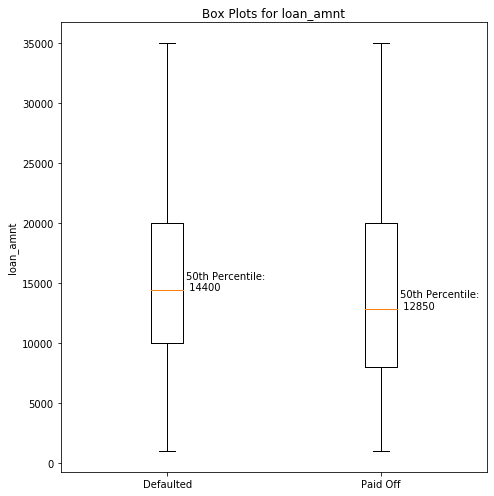

In [16]:
box_plots('loan_amnt')

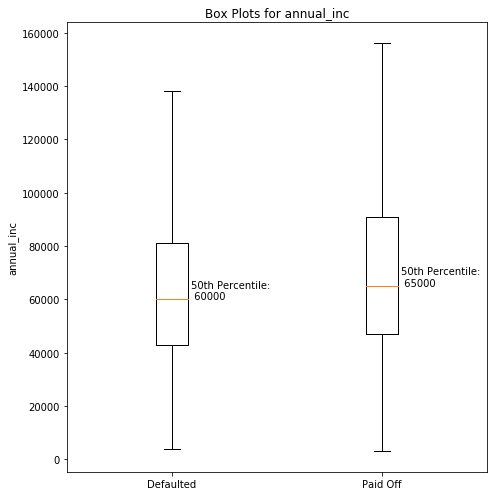

In [17]:
box_plots('annual_inc')

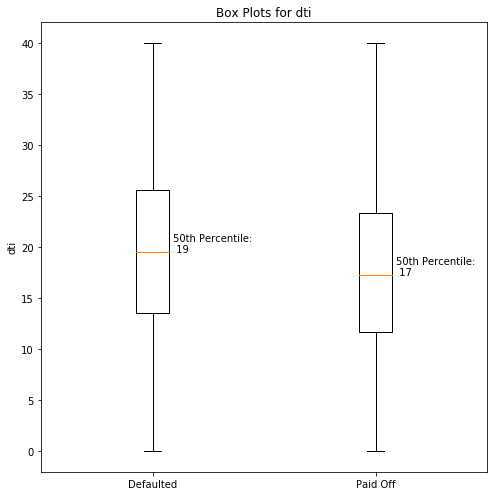

In [18]:
box_plots('dti')

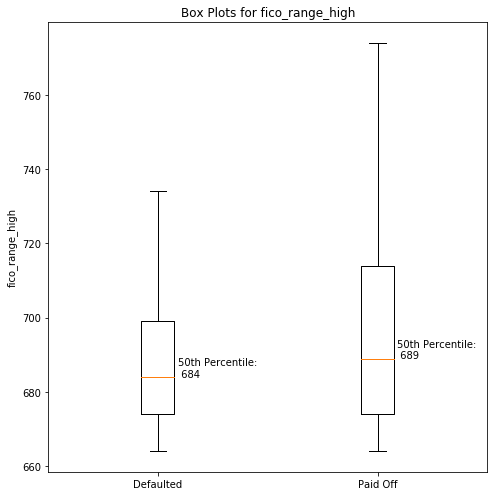

In [19]:
box_plots('fico_range_high')

<p>I'm going to look at the counts of, <code>purpose</code>, this feature is a feature that seems to be generated by the form that individuals use when they apply for a loan.</p> <p>I'll generate a bar chart similarly to how I generated the bar chart earlier with <code>loan_status</code>, except this time I'll include a second bar to deviate from defaulted loans and paid off loans.

C:\Users\Thom\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Thom\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


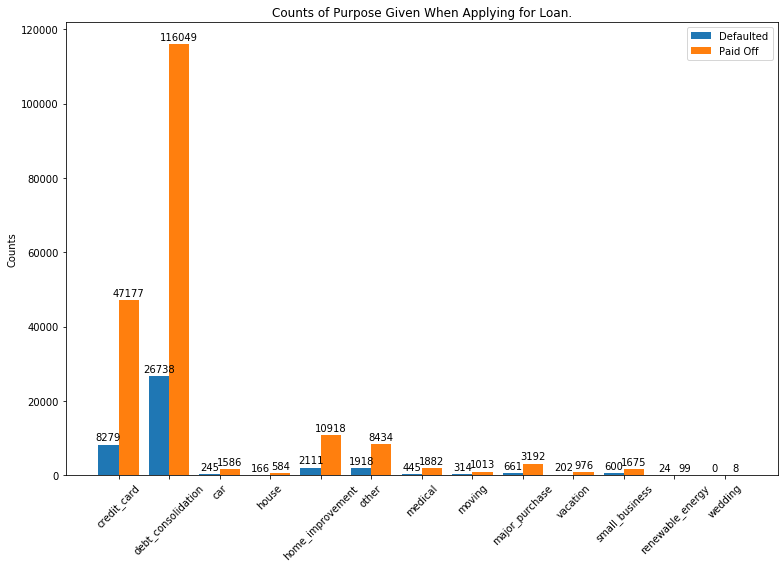

In [20]:
# the easiest way to get counts of each value of purpose between default and not
# is to loop through, this way everything stays sorted
# loop does take awhile to execute
mask_1 = (df['default']==1)
mask_0 = (df['default']==0)

labels=df['purpose'].unique()
counts_1=['' for i in labels]
counts_0=['' for i in labels]
for i in range(len(labels)):
    new_df = df[mask_1]
    count1 = len(new_df[df['purpose']==labels[i]])
    counts_1[i] = count1
    new_df = df[mask_0]
    count0 = len(new_df[df['purpose']==labels[i]])
    counts_0[i] = count0

# x axis
x = np.arange(len(labels))
width = .4

# plotting counts
fig,ax = plt.subplots(figsize=(11,8))
rect1 = plt.bar(x - width/2,counts_1,width,label='Defaulted')
rect0 = plt.bar(x + width/2,counts_0,width,label='Paid Off')
plt.xticks(x,labels,rotation=45)
plt.ylabel('Counts')
plt.title('Counts of Purpose Given When Applying for Loan.')
ax.legend()

autolabel(rect1,'%i')
autolabel(rect0,'%i')        
    
fig.tight_layout()
plt.show()

<p>Regression models require that all features be in type of integer or floating point. We must <b>dummy</b> the <code>purpose</code> feature so that it is compatible with model training.</p> <p> We do this by using <code>pd.get_dummies()</code> from the <code>pandas</code> framework.</p>

In [21]:
df = pd.concat([df,pd.get_dummies(df['purpose'], prefix='purpose')],axis=1)
df.drop(columns=['purpose'],inplace=True)

Before moving onto model selection I need to convert <code>term</code> to a integer. 

In [22]:
df['term'] = [i[0:3] for i in df['term']]

<p>I am happy with my data, so we will move onto the model selection process. We will train and fit the data on classifiers from <code>scikit-learn</code> package.</p> <p>Begin by splitting my data into $X$ and $y$. $X$ will be the dependent variables that we have been looking at, $y$ is the state of default, either a $0$ or $1$.</p>

In [23]:
X = df.copy()
X.drop(columns=['default'],inplace=True)
y = df['default']

<p> I use <code>sklearn.model_selection.KFold</code> to fold the data into 5 different splits.</p> <p>The KFolds will be used to select the best model from Logistic Regression, K Nearest Neighbors, or Random Forest Classifier.</p> <p> We'll use <code>sklearn.model_selection.cross_val_score</code> to generate a cross validation score for each model. The final score is the average cross validation score from each KFolds. </p>

In [24]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

models = [(LogisticRegression(class_weight='balanced'),'Logistic Regression'),
          (RandomForestClassifier(n_estimators=10), 'Random Forest Classifier')]

kf = KFold(n_splits=5)

for model in models:
    result = cross_val_score(model[0],X,y,scoring='roc_auc',cv=kf)
    print('%s: %.2f' %(model[1],result.mean()))

Logistic Regression: 0.63
Random Forest Classifier: 0.61


<p>Now that we have decided on a the LogisticRegression as our model of choice, we can go ahead and split the data into train/test using <code>sklearn.model_selection.train_test_split</code>.</p> <p>The test size will be 25% of the dataset since it is a sufficiently large dataset and I need a good amount of defaulted loans.</p>

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

<p>We build a model pipeline using <code>sklearn.pipeline.Pipeline</code>, scaling the data with <code>sklearn.preprocessing.StandardScaler</code> and then running it through out LogisticRegression.</p>

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = Pipeline([('scaler',StandardScaler()), ('log',LogisticRegression(class_weight = 'balanced'))])

Fit the data and predict on <code>X_train</code>.

In [27]:
clf.fit(X_train,y_train)

y_train_pred = clf.predict(X_train)

We use built-in sklearn metrics for model evaluation. <code>sklearn.metrics.classification_report</code> and <code>sklearn.metrics.plot_confusion_matrix</code> are used for model evaluation.

Classification report for classifier LogisticRegression(class_weight='balanced'):
              precision    recall  f1-score   support

           0       0.89      0.64      0.74    145172
           1       0.27      0.62      0.38     31300

    accuracy                           0.63    176472
   macro avg       0.58      0.63      0.56    176472
weighted avg       0.78      0.63      0.68    176472




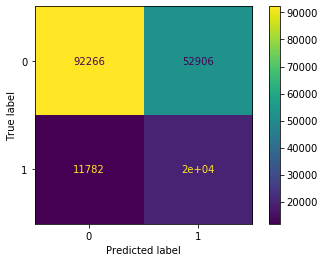

In [28]:
from sklearn.metrics import classification_report,plot_confusion_matrix

print("Classification report for classifier %s:\n%s\n" %(clf[1], classification_report(y_train, y_train_pred)))
disp = plot_confusion_matrix(clf, X_train, y_train)

The performance is ok, mode classifys ~60% correctly.

In [29]:
y_test_pred = clf.predict(X_test)

Classification report for classifier LogisticRegression(class_weight='balanced'):
              precision    recall  f1-score   support

           0       0.89      0.64      0.74     48421
           1       0.27      0.62      0.38     10403

    accuracy                           0.63     58824
   macro avg       0.58      0.63      0.56     58824
weighted avg       0.78      0.63      0.68     58824




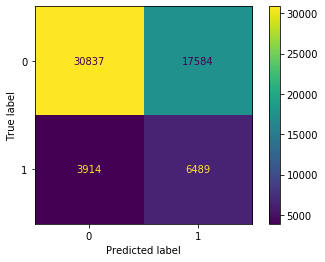

In [30]:
print("Classification report for classifier %s:\n%s\n" %(clf[1], classification_report(y_test, y_test_pred)))
disp = plot_confusion_matrix(clf, X_test, y_test)

<p>Now that I am happy with how the model is performing, I need to generate a row of data that corresponds to my own information. Then we simply run that data through the model pipeline and generate the probability of default. </p>
<p>First, get the columns for X_train and simply fill in all the values to get a row that matches the correct dimensions for the pipeline.

In [58]:
from collections import defaultdict 

me = pd.DataFrame()
to_df = []
for col in X_train.columns:
    to_df.append(input('What value for %s: '%(col)))
    me[col] = to_df
    to_df.pop(0)

What value for loan_amnt: 10000
What value for term: 60
What value for annual_inc: 28000
What value for dti: 108
What value for fico_range_high: 745
What value for acc_open_past_24mths: 2
What value for tot_cur_bal: 65000
What value for bc_util: 5
What value for mort_acc: 0
What value for purpose_car: 1
What value for purpose_credit_card: 0
What value for purpose_debt_consolidation: 0
What value for purpose_home_improvement: 0
What value for purpose_house: 0
What value for purpose_major_purchase: 0
What value for purpose_medical: 0
What value for purpose_moving: 0
What value for purpose_other: 0
What value for purpose_renewable_energy: 0
What value for purpose_small_business: 0
What value for purpose_vacation: 0
What value for purpose_wedding: 0


In [60]:
my_probability = clf.predict_proba(me)

In [62]:
print(clf.classes_)
print(my_probability)

[0 1]
[[0.21961908 0.78038092]]


So to summarize, I probably will not be getting that \\$10,000 car loan. There is a 78\% chance that I will default on a \\$10,000 car loan given my financial summary. I guess that is the sad reality for college grads, they should probably look to buying cheap second hand cars.